## Pytorch Workflow
1. Data Prepare & load
2. Build model
3. Training, fitting data
4. Making predictions, evaluating
5. Save model & load model
6. putting together

Get data intoa numerical representation


Build a model to learn patterns in that numerica representation

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu124'

In [3]:
# Create *know* parameters
weight = 0.7
bias = 0.3

start=0
end=1
step=0.02

X = torch.arange(start,end,step).unsqueeze(dim=1)
Y = weight * X + bias

In [4]:
X[:10],Y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [5]:
len(X),len(Y)

(50, 50)

## Splitting data into training and test set

Create a train/test split

In [6]:
train_split = int(0.8*len(X))
X_train,Y_train = X[:train_split],Y[:train_split]
X_test,Y_test = X[train_split:],Y[train_split:]

In [7]:
len(X_train),len(Y_train),len(X_test),len(Y_test)

(40, 40, 10, 10)

Building a function to Visualize my data

In [8]:
def plot_predictions(
    train_data=X_train,
    train_labels=Y_train, # 'train_labels' represents the actual target values (labels) corresponding to the training data.
    test_data=X_test,
    test_labels=Y_test,
    predictions=None,):

  """
  Plots training data, test data and compares predictions
  """
  plt.figure(figsize=(10,7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=5, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=5, label="Testing data")

  if predictions is not None:
    # Plot the predictions if exist
    plt.scatter(test_data, predictions, c="r", s=5, label="Prediction data")

  # Show the legend
  plt.legend(prop={"size":14})

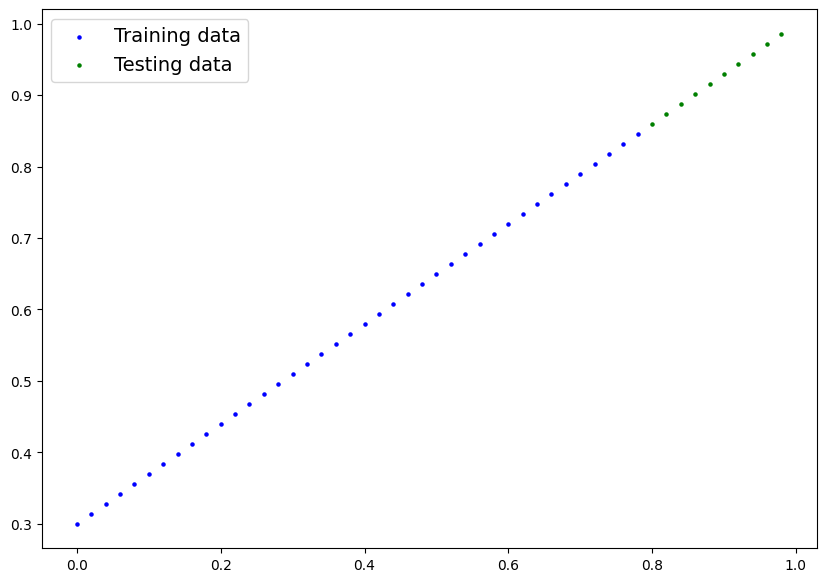

In [9]:
plot_predictions()

## Build model

Building class:
https://realpython.com/python3-object-oriented-programming/

Base class for all neural network modules.

https://pytorch.org/docs/stable/generated/torch.nn.Module.html

### What Our Model Does

- **Start with random values** (weight & bias)
- **Look at training data** and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

#### How Does It Do So?

Through two main algorithms:

1. **Gradient Descent**
2. **Backpropagation**

#### this model's building essentials:
1. `nn.Module` contains the larger building blocks (layers)
2. `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make nn.Module(s))
3. `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within nn.Module(s)

In [10]:
from torch import nn

#Create liear regression model class
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()

    # Define trainable parameter for the model
    self.weight = nn.Parameter(torch.randn(1,
                         requires_grad=True,
                         dtype=torch.float))

    self.bias = nn.Parameter(torch.randn(1,
                        requires_grad=True,
                        dtype=torch.float))

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """
    Defines the forward pass of the neural network.
    Args:
        x (torch.Tensor): The input tensor to the model.
    Returns:
        torch.Tensor: The output tensor after processing.
    """
    return self.weight * x + self.bias

### Pytorch model building essentials
* torch.nn      - for computational graphs
* torch.nn.Parameter - for model to learn and try parameters(ofen in a pytorch layer)
* torch.nn.Module   - The base class for all neural network modules, overwrite forward if subclassed
* def forward    - define model's forward computation

more:https://pytorch.org/tutorials/beginner/ptcheat.html

### Checking the contents of PyTorch model
`.parameters()` for check out model parameters or what's inside our model

In [56]:
# Create a random seed
torch.manual_seed(4221)

# Create an instance of the model
model_0 = LinearRegressionModel()

model_0

LinearRegressionModel()

In [57]:
# Check out parameters
model_0.parameters()
list(model_0.parameters())

[Parameter containing:
 tensor([-0.9314], requires_grad=True),
 Parameter containing:
 tensor([-0.6524], requires_grad=True)]

In [58]:
# List named parameters
model_0.state_dict()

OrderedDict([('weight', tensor([-0.9314])), ('bias', tensor([-0.6524]))])

### Making prediction using torch.inference_mode()
* Using X_test to predicts y_test.
* Run data through the forward() method
* using `inference_mode()``torch.no_grad()` to turn of gradient tracking, and save a lot of time

In [59]:
X_test, Y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [60]:
# Making predictions with model
# with torch.inference_mode():
#   y_preds = model_0(X_test)
with torch.no_grad():
  y_preds = model_0(X_test)
y_preds

tensor([[-1.3975],
        [-1.4161],
        [-1.4348],
        [-1.4534],
        [-1.4720],
        [-1.4906],
        [-1.5093],
        [-1.5279],
        [-1.5465],
        [-1.5652]])

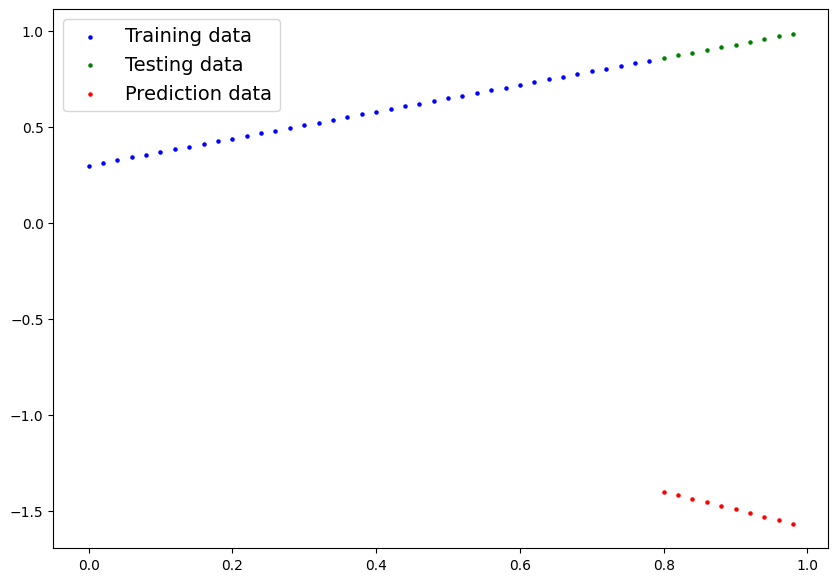

In [61]:
plot_predictions(predictions=y_preds)

### Train model
**The whole idea:** move from some unknown parameters to some known parameters.
(from poor representation of data to a better representation of data)

* Representation can be measured by loss function.

**Things we need to train:**
1. **Loss function:** A function to measure how wrong your model's predictions are, the lower the better.
2. **Optimizer**: Take into accout the loss of a model, adjusts the model's parameters to improve the loss. --https://pytorch.org/docs/stable/optim.html

For Pytorch:
* A training loop
* A testing loop

In [62]:
# Check out model's parameter(parameter value are seted by model itself)
model_0.state_dict()

OrderedDict([('weight', tensor([-0.9314])), ('bias', tensor([-0.6524]))])

In [63]:
# Set up a loss function
loss_fn = nn.L1Loss()

Iside the optimizer:

* **parameter**:the parameter my model should optimize
* **lr for learning rate:**define how big/small the optimizer changes the parameter.

  * The smaller lr, the smaller the change in parameter


In [64]:
import torch.optim
# Setup an Optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                          lr=0.1)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### Building a training loop(and a testing loop) in PyTorch
0. Loop through the data and do the followings:
1. Forward pass    -- involves data moving through our model's `forward()`function to make predictions on propagation
2. Caculate the loss --compare forward pass predictions to ground truth labels
3. Optimize zero grad
4. Loss backward(**back propagation**) -- move backwards through the network to caculate the gradient of each parameters of my model(with respect to the loss)
5. Optimize step(**gradient descent**) --use optimizer to adjust my model's parameter to try and improve the loss


In [65]:
# An epoch is one loop through the data(hyperparameter )
epochs = 1000

### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # set all parameters need gradient

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Caculate the loss
  loss = loss_fn(y_pred,Y_train)
  print(f"Loss: {loss}")

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform back propagation on the loss with respect to the parameters of model
  loss.backward() # avoid optimizer accumulate the changes in every loop

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop

  # Testing
  model_0.eval()

  print(f"parameter:{model_0.state_dict()}")

Loss: 1.5886412858963013
parameter:OrderedDict([('weight', tensor([-0.8924])), ('bias', tensor([-0.5524]))])
Loss: 1.4734309911727905
parameter:OrderedDict([('weight', tensor([-0.8534])), ('bias', tensor([-0.4524]))])
Loss: 1.358221173286438
parameter:OrderedDict([('weight', tensor([-0.8144])), ('bias', tensor([-0.3524]))])
Loss: 1.243011236190796
parameter:OrderedDict([('weight', tensor([-0.7754])), ('bias', tensor([-0.2524]))])
Loss: 1.1278011798858643
parameter:OrderedDict([('weight', tensor([-0.7364])), ('bias', tensor([-0.1524]))])
Loss: 1.0125911235809326
parameter:OrderedDict([('weight', tensor([-0.6974])), ('bias', tensor([-0.0524]))])
Loss: 0.8973811864852905
parameter:OrderedDict([('weight', tensor([-0.6584])), ('bias', tensor([0.0476]))])
Loss: 0.7821711301803589
parameter:OrderedDict([('weight', tensor([-0.6194])), ('bias', tensor([0.1476]))])
Loss: 0.666961133480072
parameter:OrderedDict([('weight', tensor([-0.5804])), ('bias', tensor([0.2476]))])
Loss: 0.5517512559890747


In [66]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6544])), ('bias', tensor([0.3576]))])

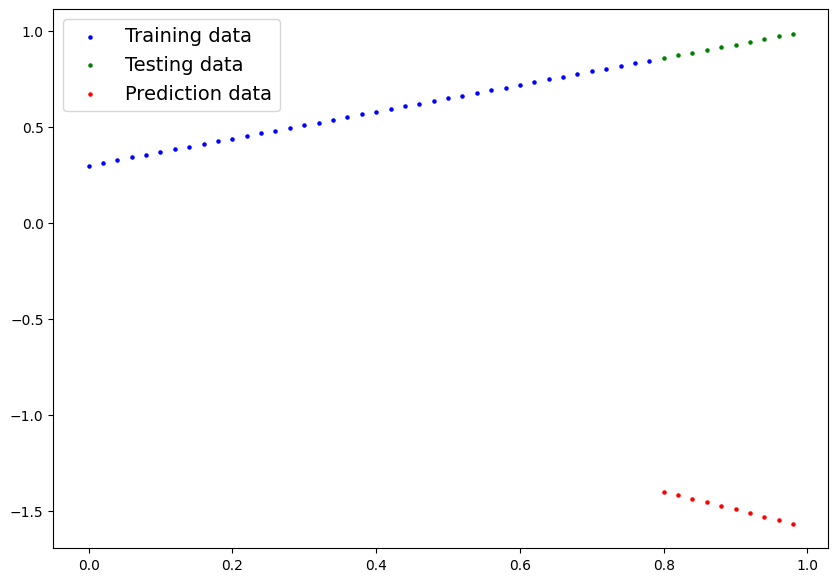

In [67]:
plot_predictions(predictions=y_preds)

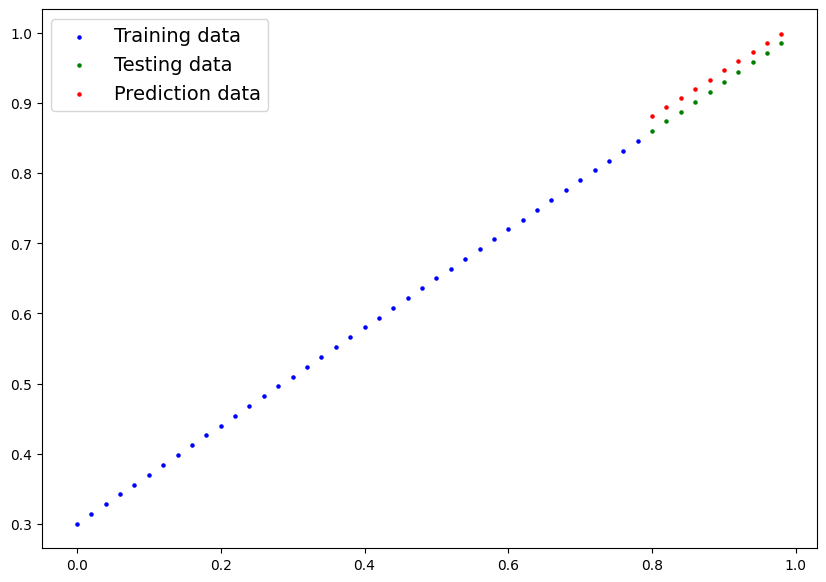

In [68]:
with torch.no_grad():
  y_preds_new = model_0(X_test)

plot_predictions(predictions=y_preds_new)